## Quick Links

1. seamless_communication GitHub repository: https://github.com/facebookresearch/seamless_communication
2. fairseq2 Github repository: https://github.com/facebookresearch/fairseq2
3. HuggingFace: https://huggingface.co/collections/facebook/seamless-communication-6568d486ef451c6ba62c7724
4. Seamless demos: https://seamless.metademolab.com/
5. Opus Books Datasets For enlish to different languages : https://huggingface.co/datasets/opus_books/tree/main

### Set up seamless_communication, fairseq2 and some utilities.

In [1]:
%%capture
!pip install fairseq2
!pip install pydub sentencepiece
!pip install git+https://github.com/facebookresearch/seamless_communication.git

In [2]:
import io
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
import mmap
import numpy
import soundfile
import torchaudio
import torch

from collections import defaultdict
from IPython.display import Audio, display
from pathlib import Path
from pydub import AudioSegment

from seamless_communication.inference import Translator
from seamless_communication.streaming.dataloaders.s2tt import SileroVADSilenceRemover
from datasets import load_dataset, load_metric
from huggingface_hub import notebook_login
from nltk.translate.bleu_score import sentence_bleu

# SeamlessM4T Inference:

## Initialize the models:

In [3]:
# Initialize a Translator object with a multitask model, vocoder on the GPU.

model_name = "seamlessM4T_v2_large"
vocoder_name = "vocoder_v2" if model_name == "seamlessM4T_v2_large" else "vocoder_36langs"

translator = Translator(
    model_name,
    vocoder_name,
    device=torch.device("cuda:0"),
    dtype=torch.float16,
)

100%|██████████| 8.45G/8.45G [06:57<00:00, 21.7MB/s]
100%|██████████| 360k/360k [00:00<00:00, 17.2MB/s]
100%|██████████| 4.93M/4.93M [00:00<00:00, 154MB/s]
Using the cached tokenizer of seamlessM4T_v2_large. Set `force` to `True` to download again.
100%|██████████| 160M/160M [00:00<00:00, 223MB/s]
/usr/local/lib/python3.10/dist-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


# Steps to Calculate Similarity Score for English to French Language Translation With SeamlessM4T_v2_large model and opus_book language translation dataset

In [4]:
def sentence_extract(raw_datasets,lang):
    for i in range(0,1000):
      if(len(str(raw_datasets["train"][i]['translation'][lang]))>300):
        return i


In [5]:
raw_datasets = load_dataset("opus_books",'en-fr')
i = sentence_extract(raw_datasets,'en')

eng = str(raw_datasets["train"][i]['translation']['en'])
fre = str(raw_datasets["train"][i]['translation']['fr'])


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/127085 [00:00<?, ? examples/s]

In [6]:
data = raw_datasets["train"][i]
data

{'id': '11',
 'translation': {'en': 'At the extreme end of the small town, a long red house with five glass doors and a Virginia creeper upon its walls ; an immense courtyard with shelters, a washhouse and a huge gateway, on the side looking towards the village; on the north side, a small gate opening on the road leading to the station three kilometres off; on the south, at the back of the house, fields, gardens, meadows joining the outskirts...such is the simple plan of this dwelling where I spent the most troubled but the most happy days of my life - the house from which we launched our adventures and to which they returned to break themselves like waves on a bare rock.',
  'fr': 'Une longue maison rouge, avec cinq portes vitrées, sous des vignes vierges, à l’extrémité du bourg ; une cour immense avec préaux et buanderie, qui ouvrait en avant sur le village par un grand portail ; sur le côté nord, la route où donnait une petite grille et qui menait vers La Gare, à trois kilomètres ; 

In [7]:
eng

'At the extreme end of the small town, a long red house with five glass doors and a Virginia creeper upon its walls ; an immense courtyard with shelters, a washhouse and a huge gateway, on the side looking towards the village; on the north side, a small gate opening on the road leading to the station three kilometres off; on the south, at the back of the house, fields, gardens, meadows joining the outskirts...such is the simple plan of this dwelling where I spent the most troubled but the most happy days of my life - the house from which we launched our adventures and to which they returned to break themselves like waves on a bare rock.'

In [8]:
fre

'Une longue maison rouge, avec cinq portes vitrées, sous des vignes vierges, à l’extrémité du bourg ; une cour immense avec préaux et buanderie, qui ouvrait en avant sur le village par un grand portail ; sur le côté nord, la route où donnait une petite grille et qui menait vers La Gare, à trois kilomètres ; au sud et par derrière, des champs, des jardins et des prés qui rejoignaient les faubourgs… tel est le plan sommaire de cette demeure où s’écoulèrent les jours les plus tourmentés et les plus chers de ma vie – demeure d’où partirent et où revinrent se briser, comme des vagues sur un rocher désert, nos aventures.'

In [9]:
!python -m spacy download fr_core_news_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 MB 13.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [10]:
import spacy
import fr_core_news_md

nlp = fr_core_news_md.load()

In [11]:
text_output, speech_output = translator.predict(
input=eng,
task_str="t2tt",
tgt_lang='fra',
src_lang='eng',
)

target = str(text_output[0])

In [12]:
target = nlp(target)
fre = nlp(fre)
target.similarity(fre)

0.9495980225779581

# Similarity Score Generator function for language translation

In [13]:
import importlib

In [14]:
def lang_download(output_languages):
  for ele in output_languages:
    lang = str(ele+"_core_news_md")
    !python -m spacy download {lang}

In [15]:
def similarity_score_generator(input_lang_code2, input_lang_code3, output_lang, language,tgt_lang):
    raw_datasets = load_dataset("opus_books",language)
    # generating raw datsaets from opus book datasets for machine translation
    i = sentence_extract(raw_datasets, input_lang_code2)
    input = str(raw_datasets["train"][i]['translation'][input_lang_code2])
    output = str(raw_datasets["train"][i]['translation'][output_lang])
    text_output, speech_output = translator.predict(
    input=input,
    task_str="t2tt",
    tgt_lang=tgt_lang,
    src_lang=input_lang_code3,
    )

    target = str(text_output[0])
    lang = str(output_lang+"_core_news_md")

    module = importlib.import_module(lang)


    nlp = module.load()
    target = nlp(target)
    output = nlp(output)

    similarity_score = target.similarity(output)

    return similarity_score


### Testing Function similarity_score_generator() with english to french opus books dataset

In [16]:
language = "en-fr"
input_lang_code2 = "en"
input_lang_code3 = "eng"
output_lang = "fr"
tgt_lang = "fra"

In [17]:
!python -m spacy download fr_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 62.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [18]:
similarity_score_generator(input_lang_code2, input_lang_code3,output_lang,language,tgt_lang)

0.9495980225779581

## Obtaining Similarity Scores from **Engish** to **Swedish, Russian, Portuguese, Polish, Dutch; Flemish, Italian, Hungarian, French, Finnish, Spanish; Castilian** Language Translation

In [19]:
languages = ['en-sv','en-ru','en-pt', 'en-pl', 'en-nl','en-it', 'en-fr','en-fi', 'en-es' ]
input_languages_code2 = [ 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en']
input_languages_code3 = ['eng', 'eng', 'eng', 'eng', 'eng', 'eng', 'eng', 'eng', 'eng']
output_languages = [ 'sv', 'ru', 'pt', 'pl', 'nl', 'it', 'fr', 'fi', 'es']
targets = ['swe','rus', 'por', 'pol', 'nld', 'ita', 'fra', 'fin', 'spa']

In [20]:
lang_download(output_languages) # downloading language corpus datasets on behalf of similarity has been checked

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.1/67.1 MB 9.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('sv_core_news_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 MB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.2/53.2 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 36.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('ru_core_news_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
     ━

In [21]:
similarity_scores = []
for i in range(0,9):
    similarity_score = similarity_score_generator(input_languages_code2[i],input_languages_code3[i],output_languages[i],languages[i],targets[i])
    similarity_scores.append(similarity_score)
    print('Similarity score of', languages[i], ' -> ', similarity_score)

Generating train split:   0%|          | 0/3095 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


Similarity score of en-sv  ->  0.7251966575283576


Generating train split:   0%|          | 0/17496 [00:00<?, ? examples/s]

Similarity score of en-ru  ->  0.9573898617176562


Generating train split:   0%|          | 0/1404 [00:00<?, ? examples/s]

Similarity score of en-pt  ->  0.9695210972215186


Generating train split:   0%|          | 0/2831 [00:00<?, ? examples/s]

Similarity score of en-pl  ->  0.8237379911983933


Generating train split:   0%|          | 0/38652 [00:00<?, ? examples/s]

Similarity score of en-nl  ->  0.9847709554495525


Generating train split:   0%|          | 0/32332 [00:00<?, ? examples/s]

Similarity score of en-it  ->  0.9574743581250564
Similarity score of en-fr  ->  0.9495980225779581


Generating train split:   0%|          | 0/3645 [00:00<?, ? examples/s]

Similarity score of en-fi  ->  0.9349174708705952


Generating train split:   0%|          | 0/93470 [00:00<?, ? examples/s]

Similarity score of en-es  ->  0.9859016511760981


## Defining plot_line_graph_function

In [24]:
def plot_line_graph(languages, similarity_scores):
    plt.figure(figsize=(10, 6))
    plt.plot(languages, similarity_scores, marker='o', color='b', linestyle='-')

    # Adding title and labels
    plt.title('Similarity Score vs. Language Translations')
    plt.xlabel('Language Translation')
    plt.ylabel('Similarity Score')

    # Rotating x-axis labels for better readability
    plt.xticks(rotation=45)

    # Displaying the plot
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## Plotting between Similarity Scores vs. Language Translation

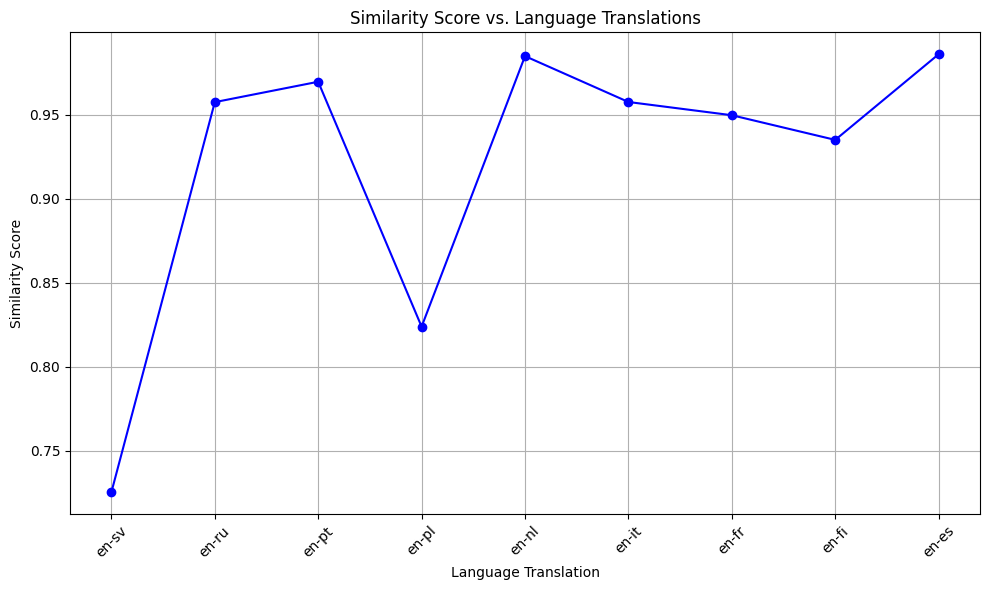

In [25]:
plot_line_graph(languages, similarity_scores)

# Obtaining Similarity Scores **German** to **English,Spanish; Castilian, French, Hungarian, Italian, Dutch; Flemish, Portuguese, Russian** Language Translation

In [26]:
languages1 = ['de-es','de-fr','de-it','de-nl','de-pt','de-ru']
input_languages_code2_1 = ['de','de','de','de','de','de']
input_languages_code3_1 = ['deu', 'deu', 'deu', 'deu', 'deu', 'deu', 'deu']
output_languages1 = ['es','fr','it','nl','pt','ru']
targets1 = ['spa', 'fra', 'ita', 'nld', 'por','rus']

In [27]:
lang_download(output_languages1) # downloading language corpus datasets on behalf of similarity has been checked

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 MB 20.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 MB 11.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 MB 14.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load(

In [28]:
similarity_scores1 = []
for i in range(0,6):
    similarity_score = similarity_score_generator(input_languages_code2_1[i],input_languages_code3_1[i],output_languages1[i],languages1[i],targets1[i])
    similarity_scores1.append(similarity_score)
    print('Similarity score of', languages1[i], ' -> ', similarity_score)

Generating train split:   0%|          | 0/27526 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


Similarity score of de-es  ->  0.9505448053195544


Generating train split:   0%|          | 0/34916 [00:00<?, ? examples/s]

Similarity score of de-fr  ->  0.9393114831671728


Generating train split:   0%|          | 0/27381 [00:00<?, ? examples/s]

Similarity score of de-it  ->  0.9085687720394758


Generating train split:   0%|          | 0/15622 [00:00<?, ? examples/s]

Similarity score of de-nl  ->  0.892999665757979


Generating train split:   0%|          | 0/1102 [00:00<?, ? examples/s]

Similarity score of de-pt  ->  0.8050984082579027


Generating train split:   0%|          | 0/17373 [00:00<?, ? examples/s]

Similarity score of de-ru  ->  0.9225470427864172


# Plotting between Similarity Scores vs. Language Translation

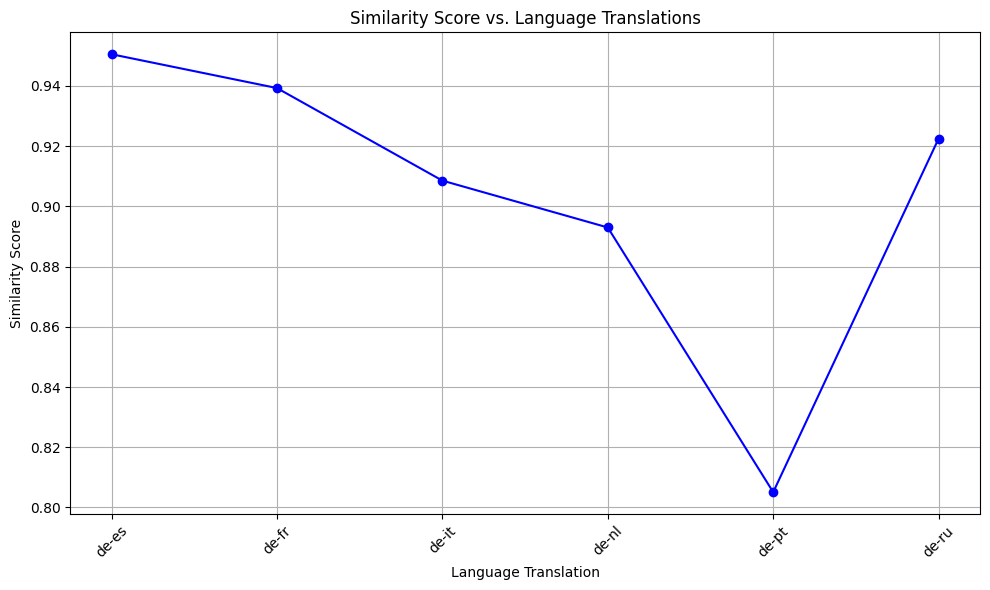

In [29]:
plot_line_graph(languages1, similarity_scores1)

# Obtaining Similarity Scores **French** to **Italian, Dutch; Flemish, Polish, Portuguese, Russian, Swedish** Language Translation


In [30]:
languages2 = [ 'fr-it', 'fr-nl', 'fr-pl', 'fr-pt', 'fr-ru', 'fr-sv']
input_languages_code2_2 = ['fr', 'fr', 'fr', 'fr', 'fr', 'fr', ]
input_languages_code3_2 = ['fra', 'fra', 'fra', 'fra', 'fra', 'fra']
output_languages2 = ['it', 'nl', 'pl', 'pt', 'ru', 'sv']
targets2 = ['ita', 'nld', 'pol', 'por','rus', 'swe']

In [31]:
lang_download(output_languages2) # downloading language corpus datasets on behalf of similarity has been checked

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 MB 23.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('it_core_news_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.7/42.7 MB 15.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('nl_core_news_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 MB 13.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load(

In [34]:
similarity_scores2 = []
for i in range(0,6):
    similarity_score = similarity_score_generator(input_languages_code2_2[i],input_languages_code3_2[i],output_languages2[i],languages2[i],targets2[i])
    similarity_scores2.append(similarity_score)
    print('Similarity score of', languages2[i], ' -> ', similarity_score)

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


Similarity score of fr-it  ->  0.9650837932479874


Generating train split:   0%|          | 0/40017 [00:00<?, ? examples/s]

Similarity score of fr-nl  ->  0.8810187529276337


Generating train split:   0%|          | 0/2825 [00:00<?, ? examples/s]

Similarity score of fr-pl  ->  0.9309041363121989


Generating train split:   0%|          | 0/1263 [00:00<?, ? examples/s]

Similarity score of fr-pt  ->  0.9162589685963031


Generating train split:   0%|          | 0/8197 [00:00<?, ? examples/s]

Similarity score of fr-ru  ->  0.689625752099825


Generating train split:   0%|          | 0/3002 [00:00<?, ? examples/s]

Similarity score of fr-sv  ->  0.2654583975633203


# Plotting Between Similarity Scores vs. Language Translation

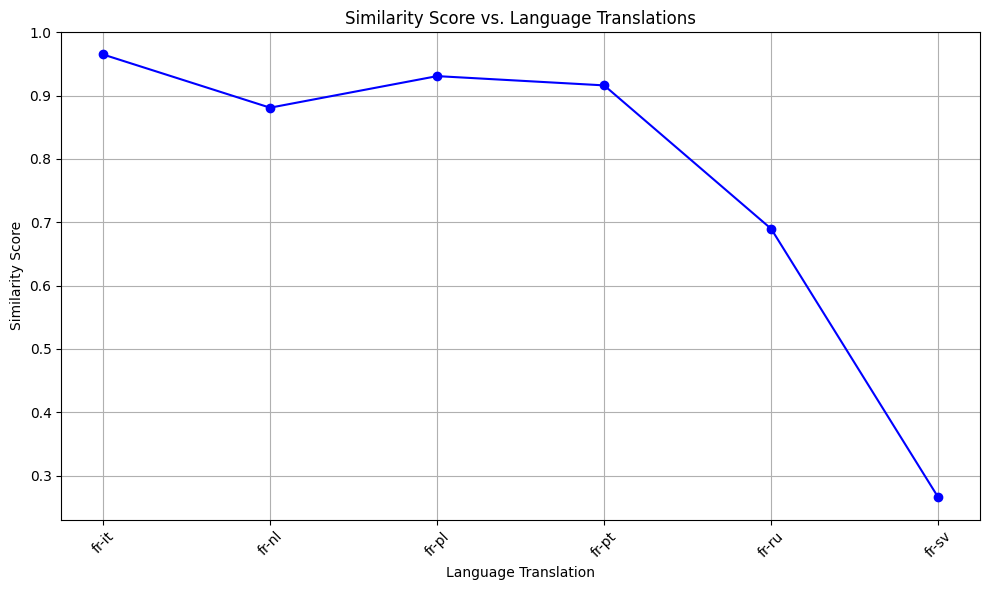

In [35]:
plot_line_graph(languages2,similarity_scores2)

# Obtaining Similarity Score From **Spanish** to **Finnish, French, Italian, Dutch; Flemish, Portuguese, Russian** Language Translation

In [36]:
languages3 = ['es-fi', 'es-fr', 'es-it', 'es-nl', 'es-pt', 'es-ru']
input_languages_code2_3 = ['es', 'es', 'es', 'es', 'es', 'es']
input_languages_code3_3 = ['spa', 'spa', 'spa', 'spa', 'spa', 'spa']
output_languages3 = ['fi', 'fr', 'it', 'nl', 'pt', 'ru']
targets3 = ['fin', 'fra', 'ita', 'nld', 'por', 'rus']

In [37]:
lang_download(output_languages3)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 MB 13.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('fi_core_news_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 MB 13.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 MB 15.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load(

In [38]:
similarity_scores3 = []
for i in range(0,6):
    similarity_score = similarity_score_generator(input_languages_code2_3[i],input_languages_code3_3[i],output_languages3[i],languages3[i],targets3[i])
    similarity_scores3.append(similarity_score)
    print('Similarity score of', languages3[i], ' -> ', similarity_score)

Generating train split:   0%|          | 0/3344 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


Similarity score of es-fi  ->  0.9188624329565102


Generating train split:   0%|          | 0/56319 [00:00<?, ? examples/s]

Similarity score of es-fr  ->  0.9601497883415153


Generating train split:   0%|          | 0/28868 [00:00<?, ? examples/s]

Similarity score of es-it  ->  0.9530067738042999


Generating train split:   0%|          | 0/32247 [00:00<?, ? examples/s]

Similarity score of es-nl  ->  0.9219521609312891


Generating train split:   0%|          | 0/1327 [00:00<?, ? examples/s]

Similarity score of es-pt  ->  0.9166395804248255


Generating train split:   0%|          | 0/16793 [00:00<?, ? examples/s]

Similarity score of es-ru  ->  0.9217563705557223


# Plotting Similarity Score vs. Language Translation

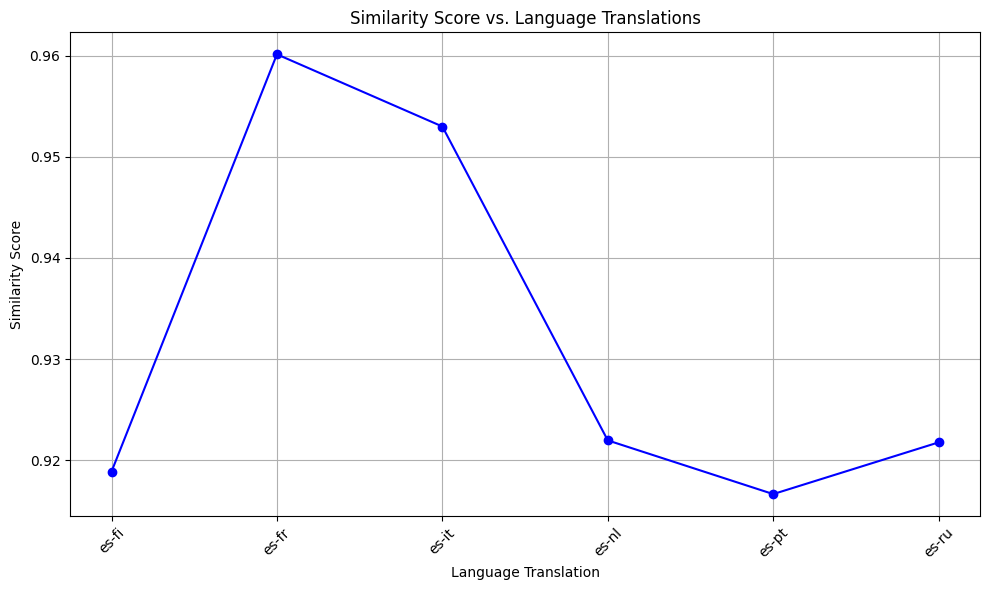

In [41]:
plot_line_graph(languages3,similarity_scores3)

# References Links
1. https://spacy.io/usage/models
2. https://www.science.co.il/language/Codes.php
3. https://github.com/facebookresearch/seamless_communication/blob/main/docs/m4t/README.md
4. https://huggingface.co/datasets/opus_books/tree/main




---



# End of NoteBook

---



In [ ]:
def reader(file_name):
  file = open(file_name, 'r')
  input =file.read()
  file.close()
  return input

In [ ]:
tgt_lang = "fra"

input = reader('input.txt')


text_output, speech_output = translator.predict(
    input=input,
    task_str="t2tt",
    tgt_lang=tgt_lang,
    src_lang="eng",
)



In [ ]:
print(text_output)

[CString('Il est arrivé à notre maison il y a près de quinze ans et n'y retournera certainement jamais.Il est arrivé à notre maison il est arrivé à notre maison il est arrivé à notre maison il est arrivé à notre maison il est arrivé à notre maison il est arrivé à notre maison il est arrivé à notre maison il est arrivé à notre maison il est arrivé à notre maison il est arrivé à notre maison il est arrivé à notre maison il est arrivé à notre maison il est arrivé à notre maison il est arrivé à notre maison il est arrivé à notre maison il est arrivé à notre maison il est arrivé à notre maison il est arrivé à notre maison il est arrivé à notre maison il est arrivé à notre maison il est arrivé à notre maison il est arrivé à notre maison il est arrivé à notre maison il est arrivé à notre maison il est arrivé à notre maison il est arrivé à notre maison il est arrivé à notre maison il est arrivé à notre maison il est arrivé à notre maison il est arrivé à notre maison il est arrivé à notre maiso

In [ ]:
def write_sentences_to_file(text_output, file_path):
    with open(file_path, 'a') as file:
        file.write(str(text_output[0]))

In [ ]:
output = "/content/output.txt"
write_sentences_to_file(text_output, output)

In [ ]:
target = reader('target.txt')

In [ ]:
from nltk.translate.bleu_score import sentence_bleu

In [ ]:
print('BLEU score -> {}'.format(sentence_bleu(output, target)))

BLEU score -> 2.939417373416477e-232


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

In [ ]:
!simuleval --source source.txt --target target.txt --agent /content/agent_with_configs.py

Traceback (most recent call last):
  File "/usr/local/bin/simuleval", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.10/dist-packages/simuleval/cli.py", line 49, in main
    system, args = build_system_args()
  File "/usr/local/lib/python3.10/dist-packages/simuleval/utils/agent.py", line 143, in build_system_args
    system = system_class.from_args(args)
  File "/usr/local/lib/python3.10/dist-packages/simuleval/agents/agent.py", line 185, in from_args
    return cls(args)
  File "/content/agent_with_configs.py", line 22, in __init__
    with open(args.vocab) as f:
TypeError: expected str, bytes or os.PathLike object, not NoneType
